# Fit Convergent Cross Mapping Model to Data Sets

In [1]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# from 2012-2020 9 years in total, 12 months for each year
merged_data = pd.read_csv('C:\\Users\\86156\\Desktop\\project\\mergedtemperature.csv',index_col=0)
merged_data = merged_data.sort_values(by=['year','month'],ascending=[True, True])

In [3]:
merged_data.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),abbr,full,population,actual_rape_total,Temperature,tweet_proportion
0,al,2012,1,51744.00000,3.00,367.000000,al,Alabama,4834334,106,50.1,0.000058
108,ak,2012,1,20125.60000,1.35,375.962006,ak,Alaska,735190,39,-12.8,0.000067
216,az,2012,1,57016.09091,1.00,99.781590,az,Arizona,6572455,205,45.3,0.000018
324,ar,2012,1,7733.00000,1.00,212.571483,ar,Arkansas,2981157,108,44.6,0.000129
432,ca,2012,1,134228.00000,5.00,547.446496,ca,California,38183375,671,46.5,0.000037


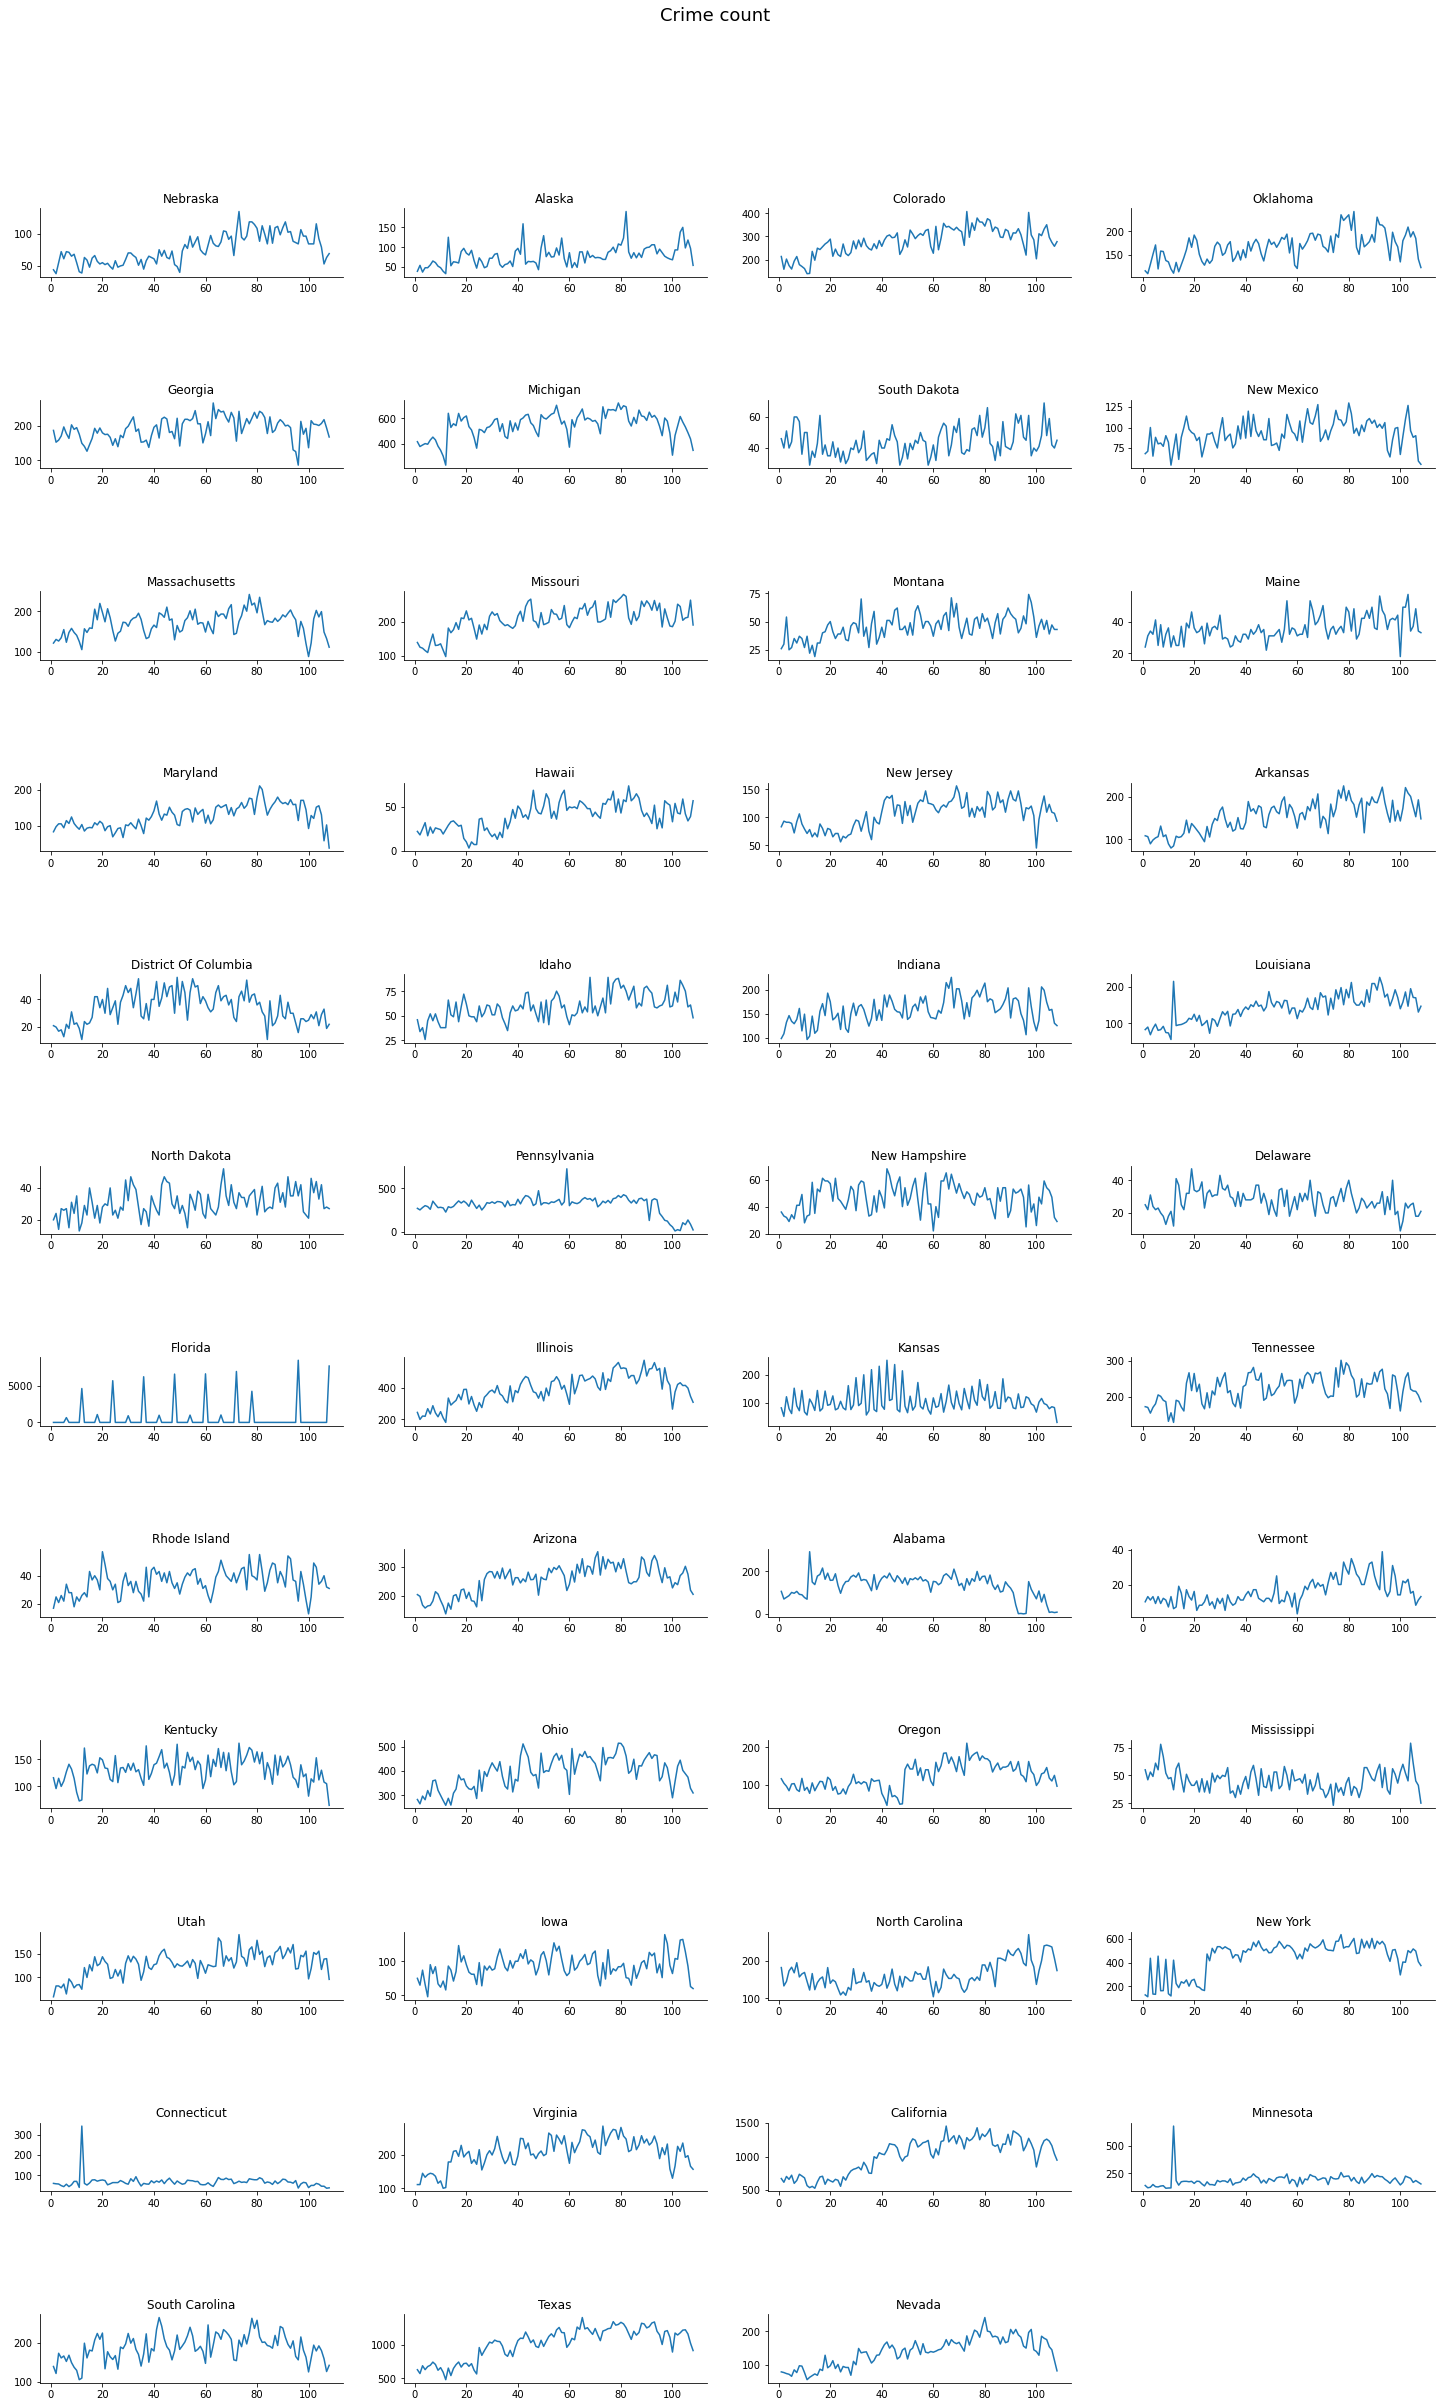

In [22]:
plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Crime count", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()

    x1_rape_total = data['actual_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(np.arange(1,109),x1_rape_total)
    ax.set_title(curr_state)
    sns.despine()

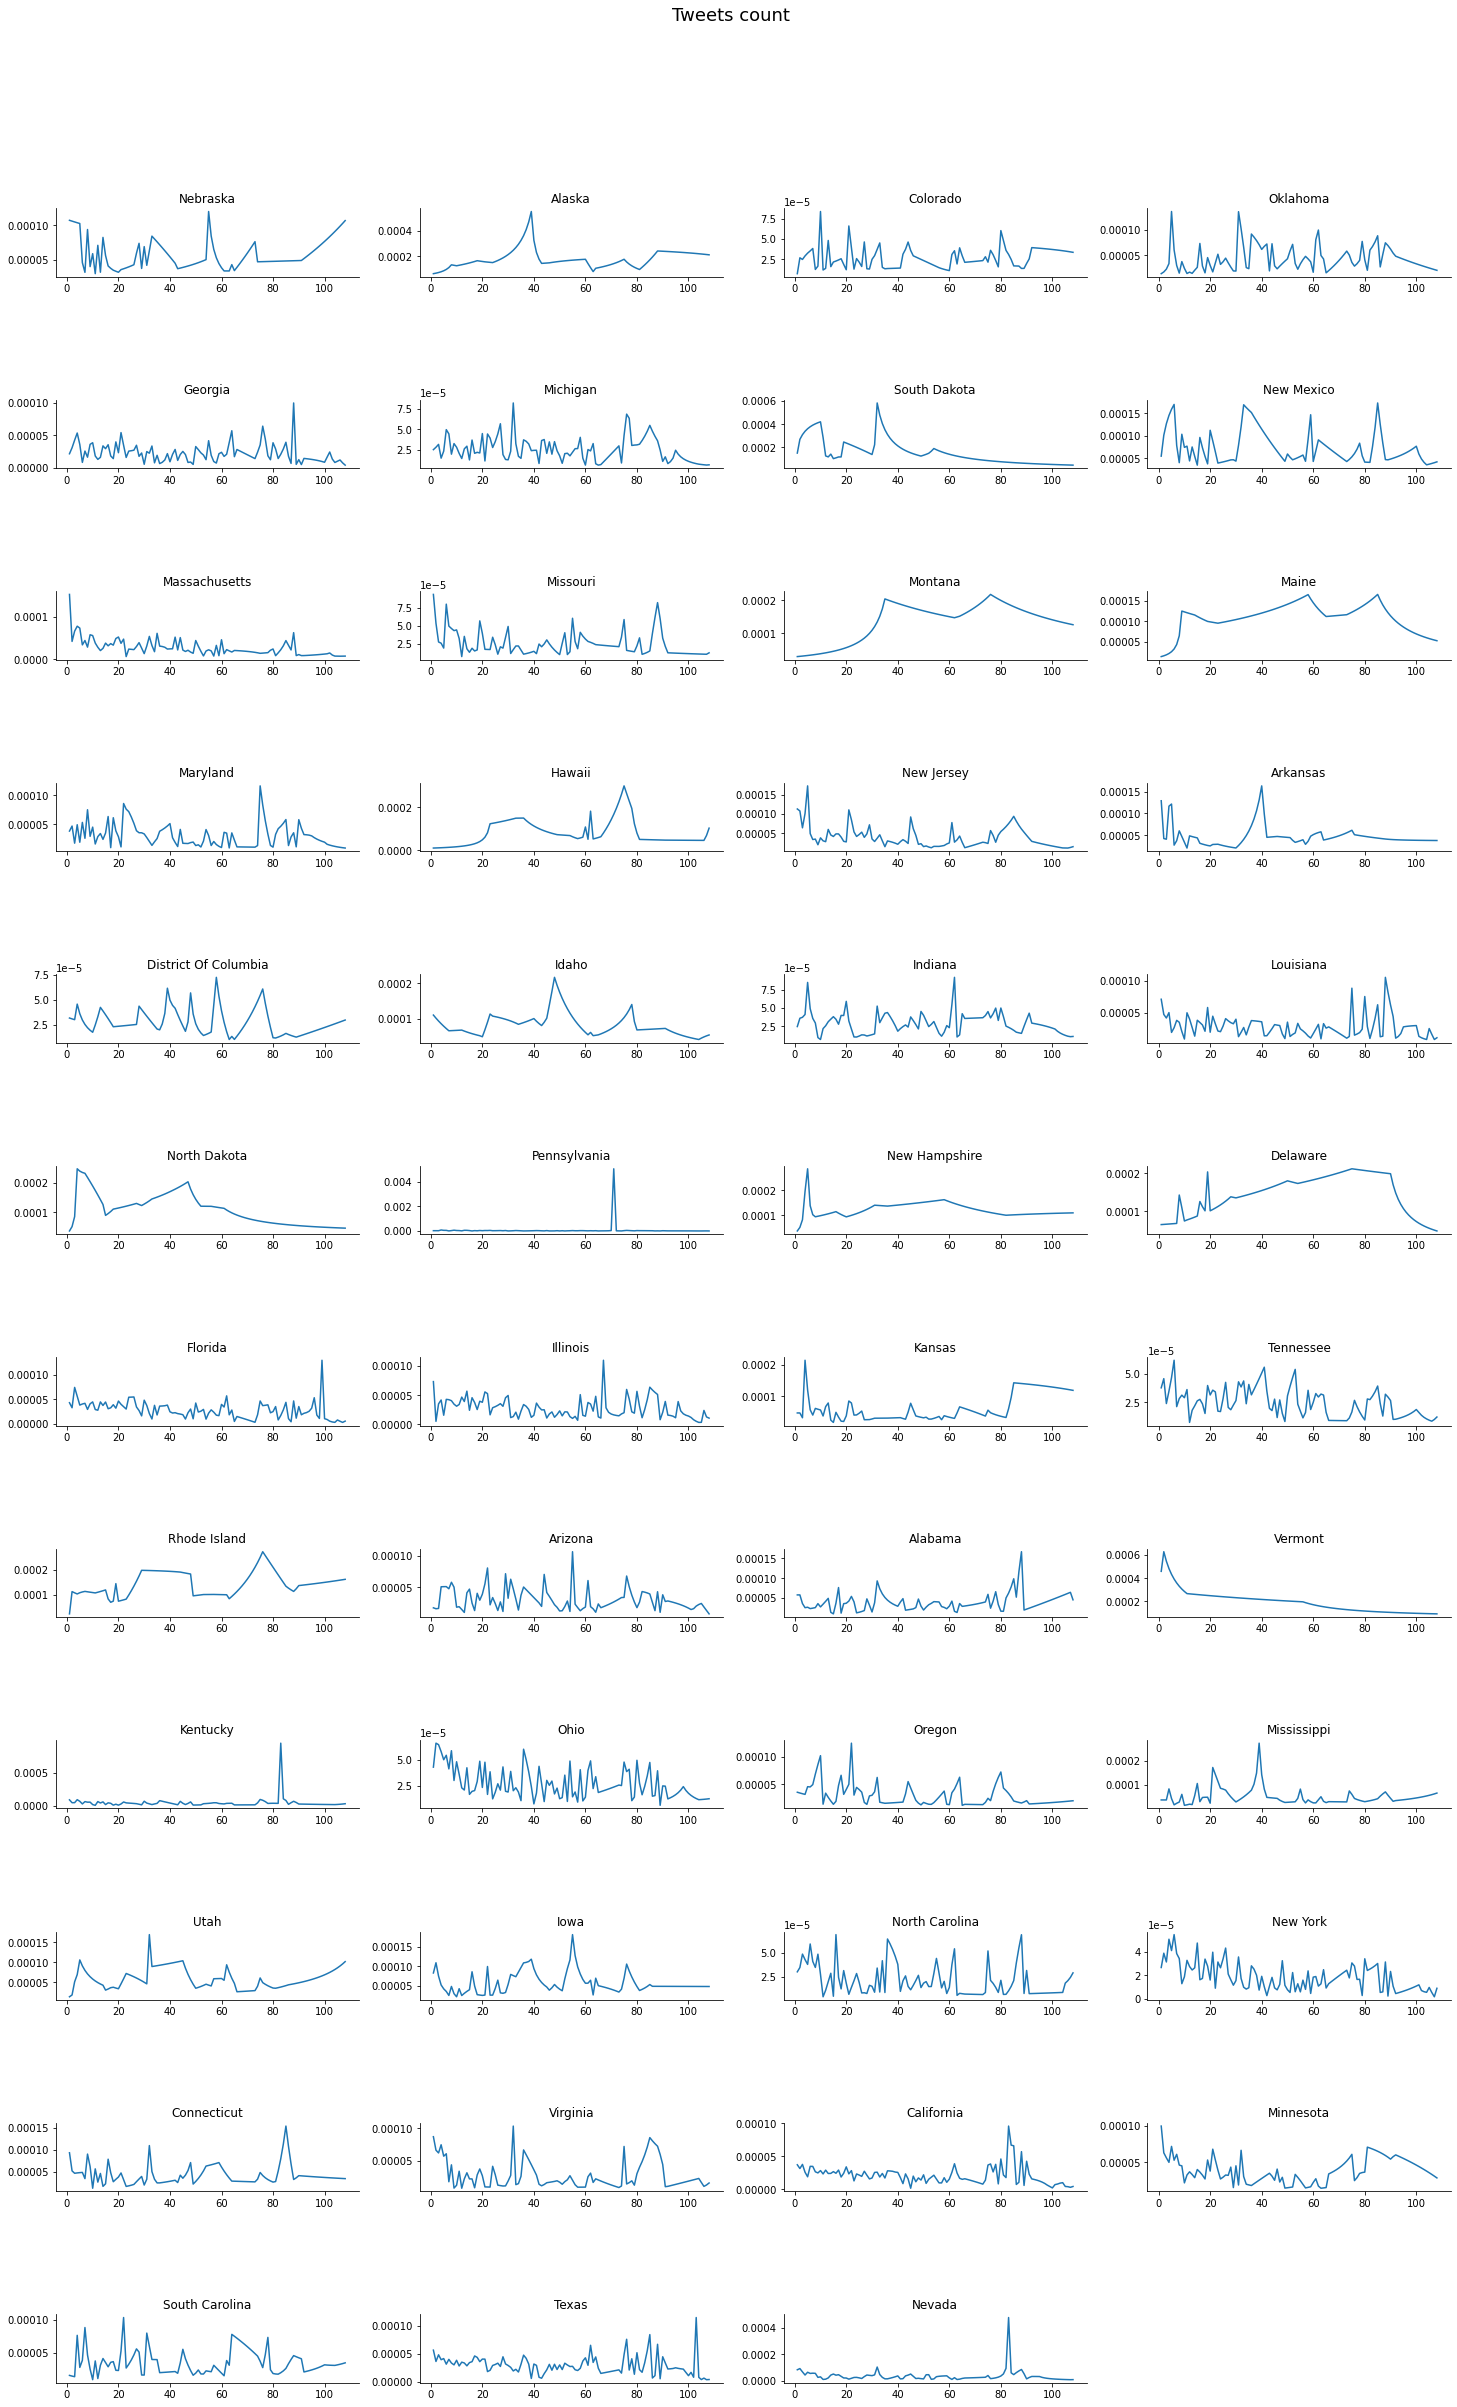

In [23]:
plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Tweets count", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    x2_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    

    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(np.arange(1,109),x2_misogyny_proportion)
    ax.set_title(curr_state)
    sns.despine()

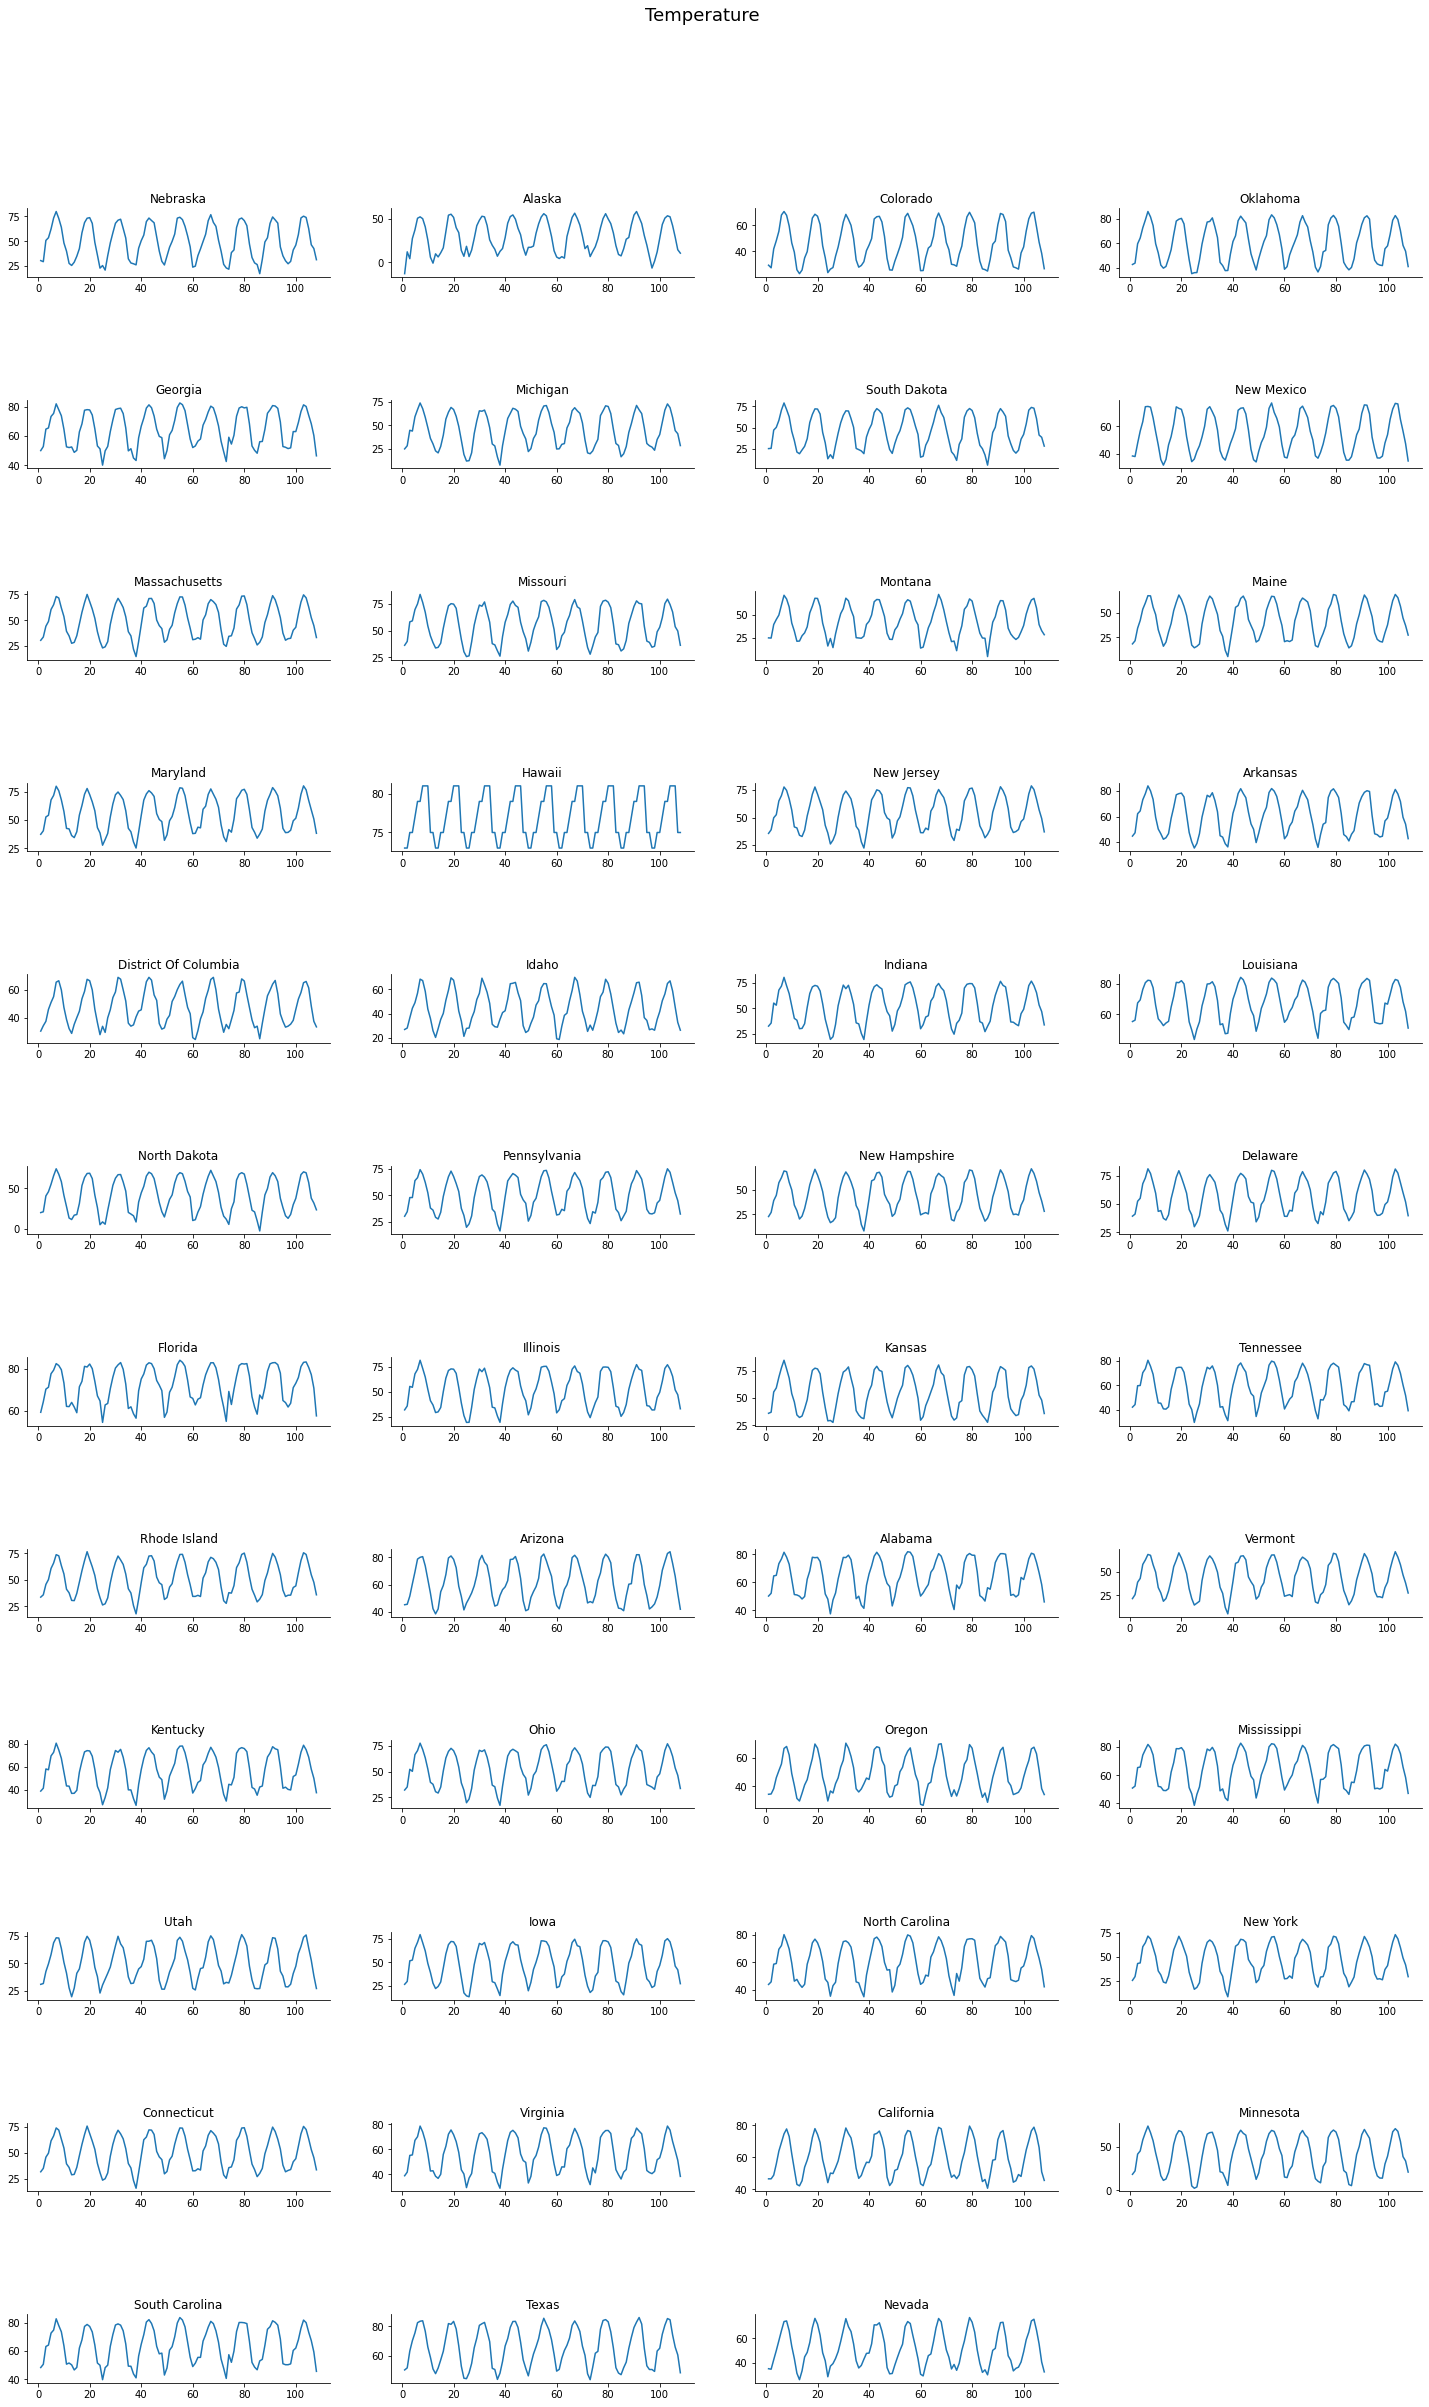

In [24]:
plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Temperature", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    x2_misogyny_proportion = data['Temperature'].to_numpy()
    

    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(np.arange(1,109),x2_misogyny_proportion)
    ax.set_title(curr_state)
    sns.despine()

# Temperature vs Crime

## Part A: State-wise

In [4]:
state_list = list(set(merged_data['USstate'].to_list()))
print(state_list)

['ne', 'ak', 'co', 'ok', 'ga', 'mi', 'sd', 'nm', 'ma', 'mo', 'mt', 'me', 'md', 'hi', 'nj', 'ar', 'dc', 'id', 'in', 'la', 'nd', 'pa', 'nh', 'de', 'fl', 'il', 'ks', 'tn', 'ri', 'az', 'al', 'vt', 'ky', 'oh', 'or', 'ms', 'ut', 'ia', 'nc', 'ny', 'ct', 'va', 'ca', 'mn', 'sc', 'tx', 'nv']


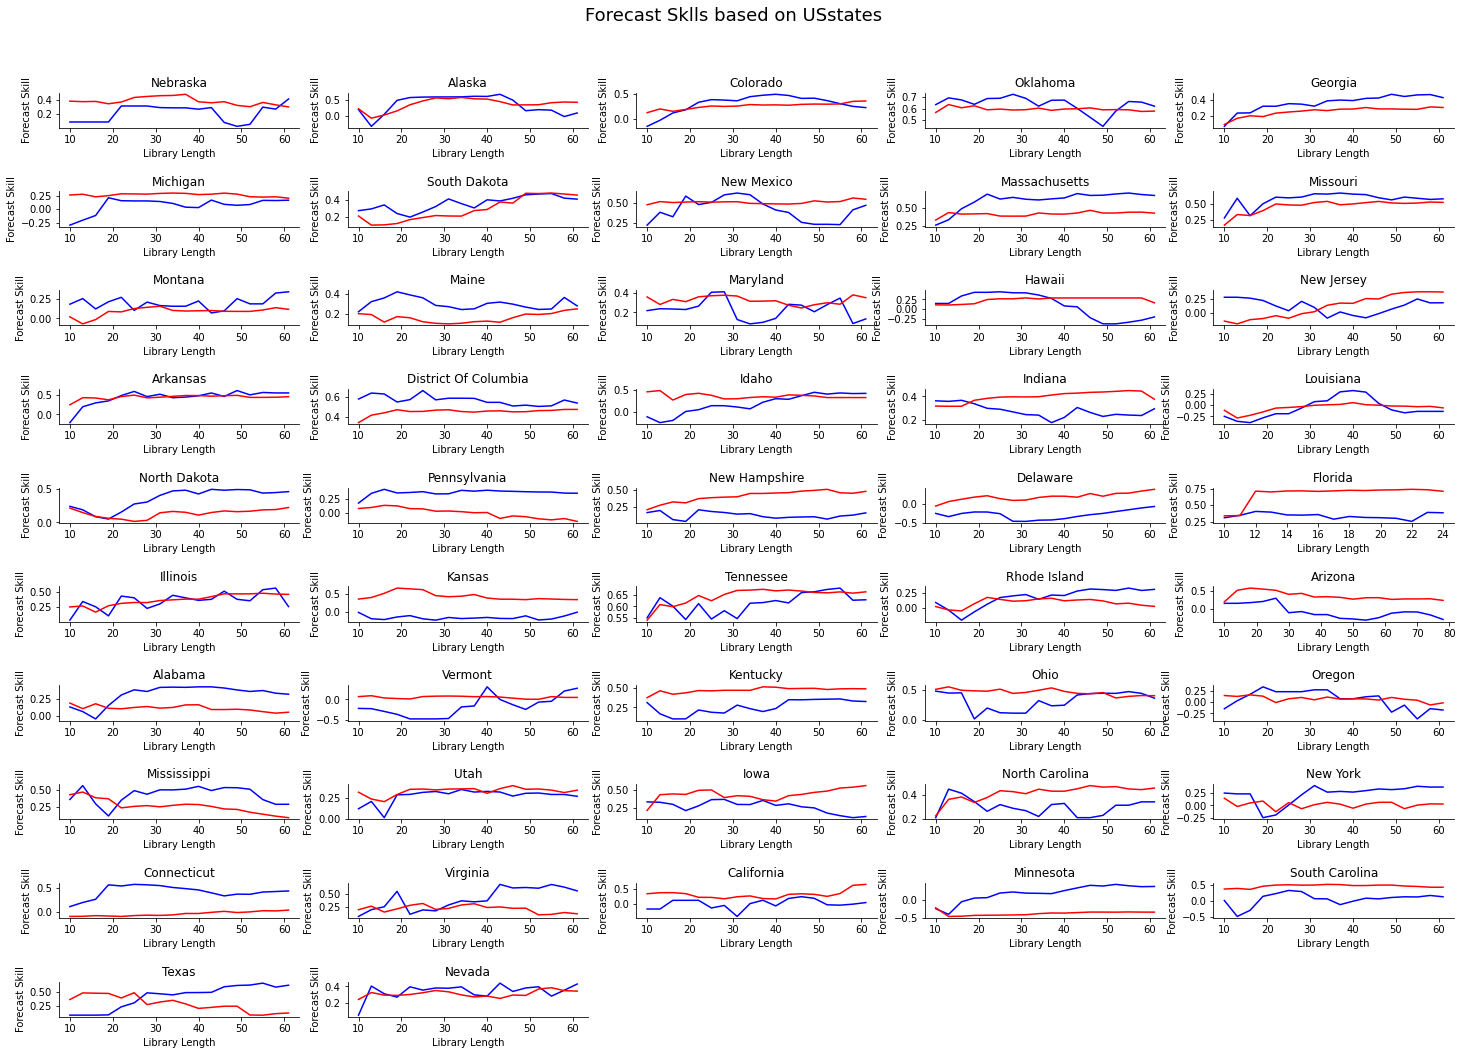

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x1_temperature = data['Temperature'].to_numpy()
    x2_crime = data['crime_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_temperature)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # temperature predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict temperature
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Temperature vs Tweets

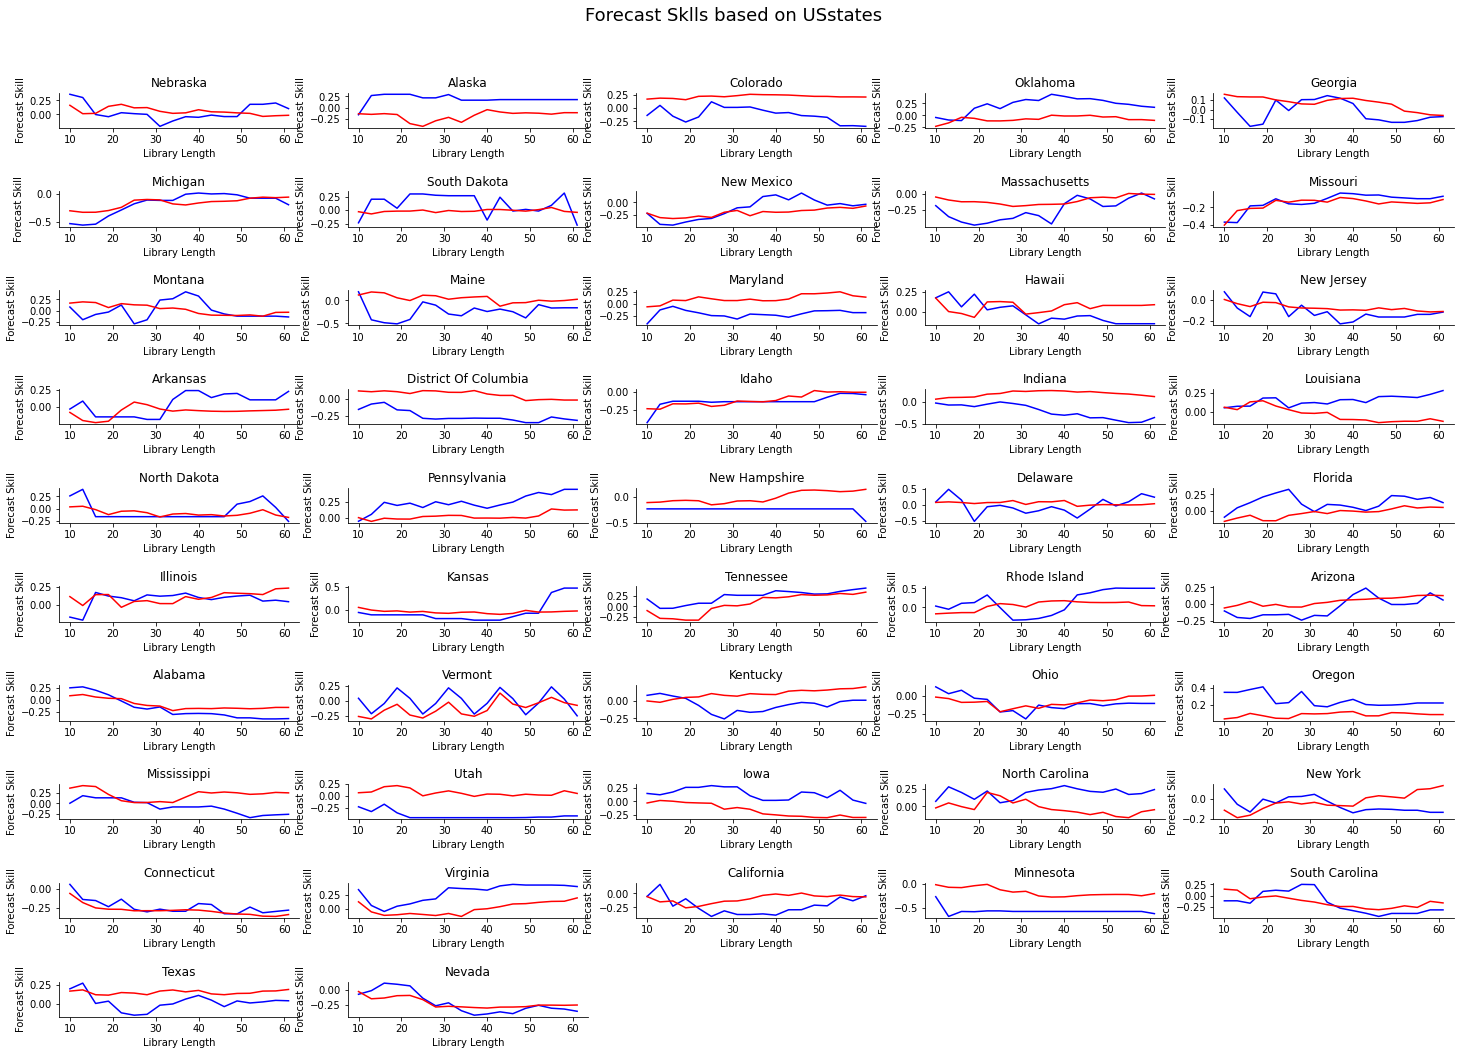

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x1_temperature = data['Temperature'].to_numpy()
    x2_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_temperature)
    e2 = ccm.Embed(x2_misogyny_proportion)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Part B: Country-wise

In [10]:
merged_data10 = merged_data
merged_data10['misogyny_proportion'] = merged_data10['nTweets_y'] / merged_data10['nTweets_x']
merged_data10 = merged_data10.groupby(['year','month']).sum()
merged_data10['shifted_rape_total'] = merged_data10['actual_rape_total'] - merged_data10['actual_rape_total'].shift(-1)
merged_data10['shifted_rape_total'] = merged_data10['shifted_rape_total'].fillna(0)
merged_data10 = merged_data10.drop(columns=['nTweets_x','nTweets_y','Number of establishments (ESTAB)','population'])
merged_data10

actual_rape_total  Temperature  tweet_proportion  \
year month                                                     
2012 1                   6010       1659.1          0.003028   
     2                   5516       1777.9          0.003103   
     3                   6430       2364.5          0.003074   
     4                   5980       2534.5          0.003904   
     5                   6251       3002.5          0.003889   
...                       ...          ...               ...   
2020 8                   9574       3470.3          0.001982   
     9                   9099       3086.0          0.002010   
     10                  8618       2571.3          0.002017   
     11                  7700       2203.3          0.002021   
     12                 14360       1693.9          0.002061   

            misogyny_proportion  shifted_rape_total  
year month                                           
2012 1                 0.003028               494.0  
     2                 0.003103              -914.0  
     3                 0.003074               450.0  
     4                 0.003904              -271.0  
     5                 0.003888              -978.0  
...                         ...                 ...  
2020 8                 0.001982               475.0  
     9                 0.002010               481.0  
     10                0.002017               918.0  
     11                0.002021             -6660.0  
     12                0.002061                 0.0  

[108 rows x 5 columns]

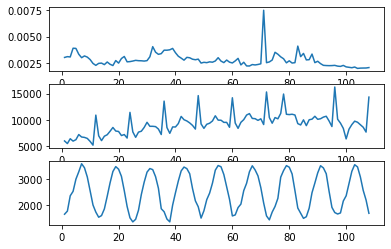

In [17]:
x1_tweet = merged_data10['misogyny_proportion'].to_numpy()
x2_crime = merged_data10['actual_rape_total'].to_numpy()
x3_temperature = merged_data10['Temperature'].to_numpy()

fig,ax = plt.subplots(nrows=3,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_tweet)
ax[1].plot(np.arange(1,109),x2_crime)
ax[2].plot(np.arange(1,109),x3_temperature)

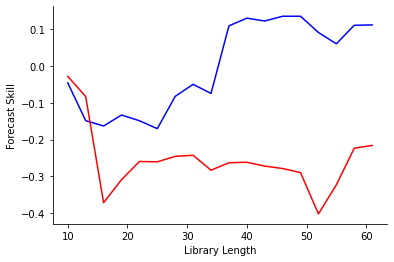

In [18]:
e1 = ccm.Embed(x1_tweet)
e2 = ccm.Embed(x3_temperature)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)

# 2. Embed the time series
perc_FNN, embed = FNN_n(x3_temperature, lag, plotting = False)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

# 3. Forecast skill as a function of library length
# split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() # initiate the class

# library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

# test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # misogyny_tweet predict temperature
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # temperature predict misogyny_tweet
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

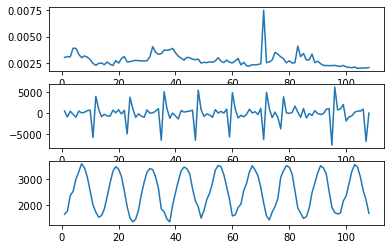

In [19]:
x3_shifted_crime = merged_data10['shifted_rape_total'].to_numpy()
x4_temperature = merged_data10['Temperature'].to_numpy()

fig,ax = plt.subplots(nrows=3,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_tweet)
ax[1].plot(np.arange(1,109),x3_shifted_crime)
ax[2].plot(np.arange(1,109),x4_temperature)

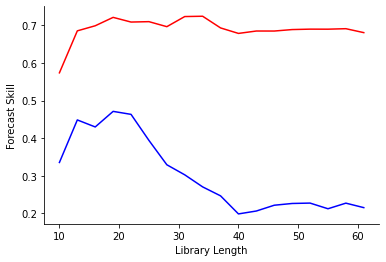

In [20]:
e1 = ccm.Embed(x4_temperature)
e2 = ccm.Embed(x3_shifted_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)

# 2. Embed the time series
perc_FNN, embed = FNN_n(x3_shifted_crime, lag, plotting = False)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

# 3. Forecast skill as a function of library length
# split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() # initiate the class

# library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

# test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # temperature predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict temperature
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()